# LULC classifictaion example
This notebook is supposed to give an example of the LULC machine learning classification pipeline used for the bachelors project of Esben Lundsgaard Palmstrøm

In [1]:
#Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon
from matplotlib import pylab as pl
from matplotlib.patches import Patch

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Machine learning 
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum

import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

import seaborn as sns;
import random
import math

## Selecting patches
First we need to select some areas, called patches, to use.

In [2]:
# Selection of patch IDs

#Short script to select a random set of patches for training and testing
#Select interval of tiles.
#All tiles will be: patchIDs = np.arange(1,618)
full_patchIDs = np.arange(1,618)
patch_subset_amount = 2
patchIDs = np.random.choice(full_patchIDs,patch_subset_amount,False)

patchIDs = [174,499] #Uncomment this line to select patches manually

#patchIDs = np.linspace(0,618,num=20,endpoint=False,dtype=int)#Uncomment this line for a list of evenly spaced numbers. Use np.linspace


#For a random set of Patches for training.
train_len = math.floor(len(patchIDs)*0.8)
test_len = len(patchIDs)-train_len
np.random.seed(0)
train_patchIDs = np.random.choice(patchIDs,train_len,False)

#Adding patches not in train to test
test_patchIDs =[]
for i in range(len(patchIDs)):
    if (patchIDs[i] not in train_patchIDs):
        test_patchIDs.append(patchIDs[i])

test_patchIDs = np.int64(test_patchIDs) # Is this necessary??

#TIME INTERVAL
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request



The selected patches are plotted

C:\Users\Esben\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


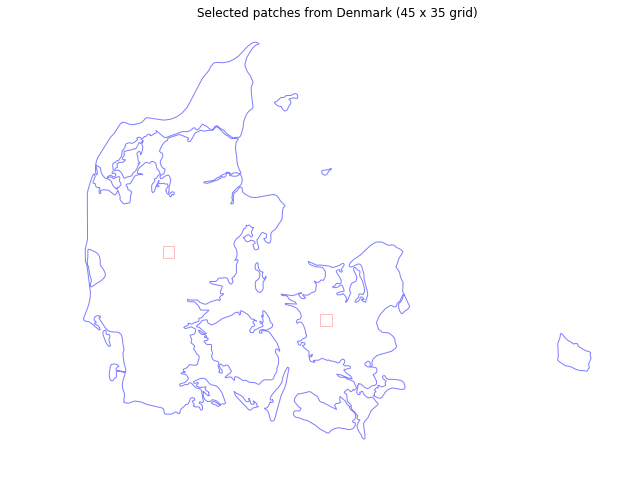

In [3]:
#Defining AOI and making Bboxes

country = gpd.read_file('./DK.geojson')

# Convert CRS to UTM_32N
country_crs = CRS.UTM_32N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]
#country.plot()
#plt.axis('off');


# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (45, 35))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (45 * 3, 35 * 3))

bbox_splitter = bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())


#Prepare info of selected patch IDs
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
gdf = gpd.GeoDataFrame(df, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

#Figure of selected patches
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected patches from Denmark (45 x 35 grid)');
plt.axis('off')
plt.savefig('Selected_patches.png')

shapefile_name =  './selected_bboxes_Denmark_large.shp'
gdf.to_file(shapefile_name)

Following section show the ID numbers for all patches

C:\Users\Esben\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


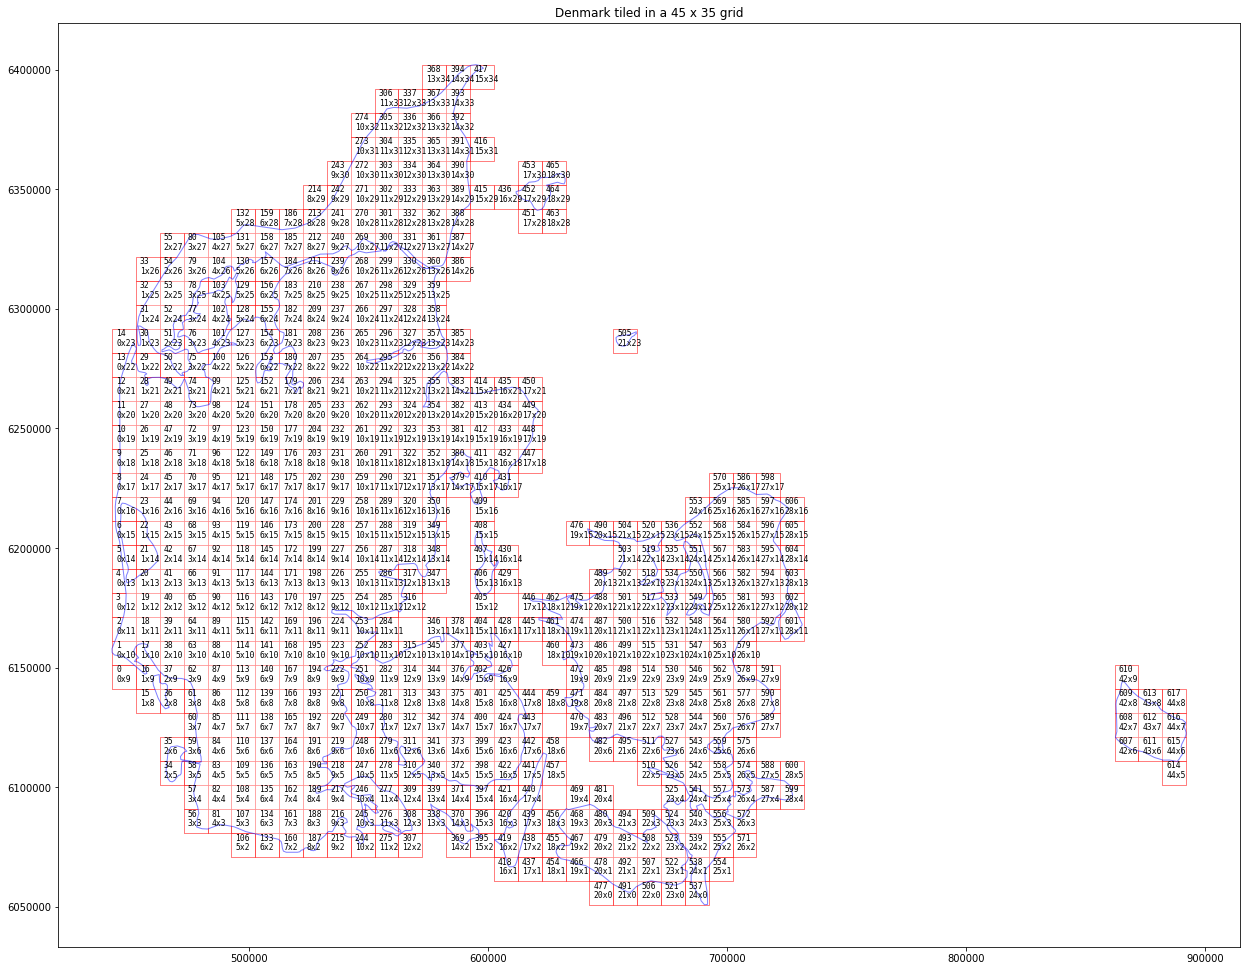

In [4]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

gdf.head()

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 8}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Denmark tiled in a 45 x 35 grid');
# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

if not os.path.isdir('./figs'):
    os.makedirs('./figs')
fig.savefig('./figs/aoi_to_tiles.png', bbox_inches='tight')

gdf.to_file('./tile-def/country_buffered_bbox_32632_45x35_618.shp')

## Data processing
For data processing, packages and examples by the eo-learn team at sentinelhub was used. Please see https://github.com/sentinel-hub/eo-learn
First some classes are defined in order to fill the selected patches with data. The last class is for working with the reference map.

In [4]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch


class NormalizedDifferenceIndex(EOTask):
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndi = (band_a - band_b) / (band_a  + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch


class EuclideanNorm(EOTask):
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name

    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))

        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

    
class LULC(enum.Enum):
    IKKE_KORTLAGT       = (0,'No data','black')
    BEBYGGELSE          = (1,'Artificial surface','crimson')
    SKOV                = (2,'Forest','xkcd:darkgreen')
    LANDBRUG            = (3,'Agriculture','xkcd:lime')
    AABEN_NATUR         = (4,'Open nature','xkcd:tan')
    VAND                = (5,'Water','xkcd:azure')


    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

feature=(FeatureType.MASK_TIMELESS, 'LULC')

lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 6, 1), lulc_cmap.N)

In [5]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12)
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './example/eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

C:\Users\Esben\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
#Execution of workflow: Filling patches with data
print('Starting download')

workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    save
)

for idx, bbox in enumerate(bbox_list[patchIDs]):

    # define additional parameters of the workflow
    extra_param = {
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }

    workflow.execute(extra_param)

print('Download finished')

Starting download
Download finished


Lets have a look at some of the data downloaded

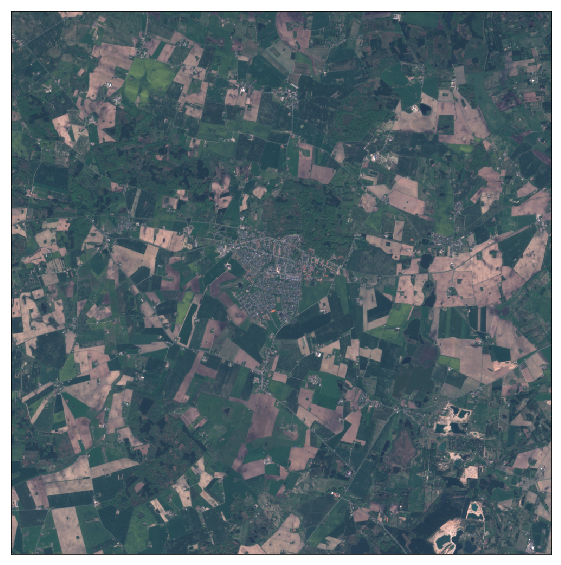

In [34]:
# True-color plot (Be wary of clouds)
fig = plt.figure(figsize=(10, 10))
eopatch = EOPatch.load('./example/eopatches_large/eopatch_1')
plt.imshow(np.clip(eopatch.data['BANDS'].squeeze()[8][..., [2, 1, 0]] * 3.5, 0, 1)) 
"""
For above plotting function:
First square bracket: Data source
Second square bracket: change picture instance/time frame
Third square bracket: Band combination
"""
plt.xticks([])
plt.yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

The reference map raster data is added manually using rasterio.

In [6]:
#Loading raster and getting coordinates and crs data.
land_cover_path = './reference_map/RefMap2.tif'
raster = rio.open(land_cover_path)



gdf = gdf.to_crs(crs=raster.crs.data)
def getFeatures(gdf,n):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][n]['geometry']]
epsg_code = int(raster.crs.data['init'][5:])


#Loop to fill all EOPatches. Data of incorrect dimensions are fitted.
for i in range(len(patchIDs)):
    coords = getFeatures(gdf,i)
    print(coords)
    out_img, out_transform = mask(dataset=raster, shapes=coords, crop=True) #Fitting raster into shape
    out_meta = raster.meta.copy()
    print(out_meta)
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )
    out_tif = os.path.join('./example/masked_ref/masked_{}.tif'.format(i))
    with rio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)
    
    arr2 = []
    
    arr2 = np.swapaxes(out_img,0,1)
    arr2 = np.swapaxes(arr2,1,2)
    
    if arr2.shape == (1005,999,1):
        arr2 = np.delete(arr2,0,axis=1)
        arr2 = np.delete(arr2,0,axis=0)        
    elif arr2.shape == (1005,1000,1):
        arr2 = np.delete(arr2,0,axis=1)
        arr2 = np.delete(arr2,0,axis=1)
        arr2 = np.delete(arr2,0,axis=0)
    elif arr2.shape == (1004,999,1):
        arr2 = np.delete(arr2,0,axis=1)
    elif arr2.shape == (1004,1000,1):
        arr2 = np.delete(arr2,0,axis=1)
        arr2 = np.delete(arr2,0,axis=1)
    
    if arr2.shape ==(1004,998,1):
        print('Correct size')
    else:
        print('wrong size')
    
    np.save('./example/eopatches_large/eopatch_{}/mask_timeless/LULC.npy'.format(i),arr2)
    
    
    

#clipped = rio.open(out_tif) # Open the last clipped raster file
# Open the clipped raster file
clipped = rio.open(out_tif)

[{'type': 'Polygon', 'coordinates': [[[512737.29929745663, 6211398.321962348], [512737.299297457, 6221436.63609163], [522719.5834201752, 6221436.636091631], [522719.5834201746, 6211398.321962348], [512737.29929745663, 6211398.321962348]]]}]
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 45995, 'height': 36828, 'count': 1, 'crs': CRS.from_dict(init='epsg:3044'), 'transform': Affine(10.0, 0.0, 433390.0002,
       0.0, -10.0, 6407850.0001)}
Correct size
[{'type': 'Polygon', 'coordinates': [[[652489.2770154853, 6151168.4371867], [652489.2770154891, 6161206.751315977], [662471.5611382056, 6161206.751315982], [662471.5611382016, 6151168.437186704], [652489.2770154853, 6151168.4371867]]]}]
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 45995, 'height': 36828, 'count': 1, 'crs': CRS.from_dict(init='epsg:3044'), 'transform': Affine(10.0, 0.0, 433390.0002,
       0.0, -10.0, 6407850.0001)}
Correct size


Plot of the reference map associated with the first patch

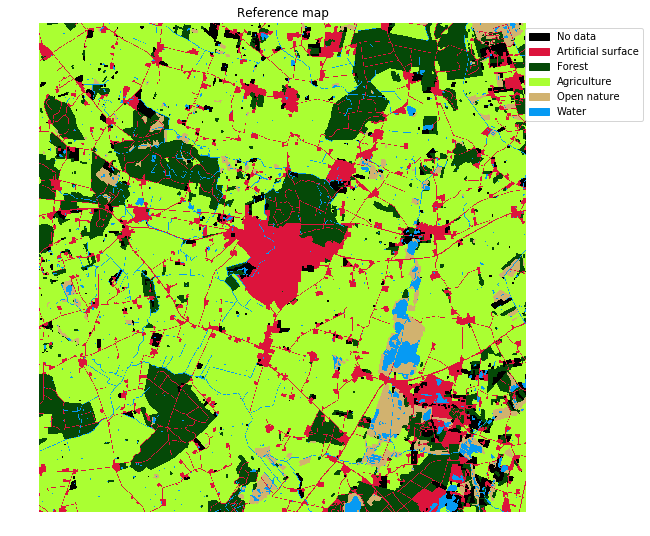

In [35]:
with rio.open('./example/masked_ref/masked_1.tif', 'r') as ds:
    arr = ds.read(1)  # read all raster values

fig, ax = plt.subplots(figsize=(13,9))
im = ax.imshow(arr,
               cmap=lulc_cmap,
               norm=lulc_norm)
ax.set_title('Reference map')

legend_labels = {'black':'No data',
                 'crimson':'Artificial surface',
                 'xkcd:darkgreen':'Forest',
                 'xkcd:lime':'Agriculture',
                 'xkcd:tan':'Open nature',
                 'xkcd:azure':'Water',
                 }

patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, 
          bbox_to_anchor=(1.25,1), 
          facecolor="white")
ax.set_axis_off()
plt.show()


The next step is to concatenate the data, filter frames with too much cloud cover. Then perform linear interpolation, erosion and random spatial sampling.

In [12]:
class ConcatenateData(EOTask):
    """
        Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch


class ValidDataFractionPredicate:
    """
    Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold


In [14]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2017-01-01', '2017-12-31', 16)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(1e5) # no. of pixels to sample
ref_labels = [0,1,2,3,4,5] # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples,
    ref_mask_feature='LULC_ERODED',
    ref_labels=ref_labels,
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ])

path_out_sampled = './example/eopatches_sampled_large/'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [15]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

In [16]:
# Running workflow

print('Starting data processing')
# Execute the workflow
for i in range(len(patchIDs)):
    # define additional parameters of the workflow
    extra_param = {
        load: {'eopatch_folder': 'eopatch_{}'.format(i)},
        save: {'eopatch_folder': 'eopatch_{}'.format(i)}
    }
    
    workflow.execute(extra_param)

print('Data processing finished')

Starting data processing
Data processing finished


## Machine Learning
The downloaded data are used to train a model. One patch is used as training data, and the other for validation.

In [36]:
eopatches = []
path_out_sampled = './example/eopatches_sampled_large/'

for i in range(len(patchIDs)):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True))

eopatches = np.array(eopatches)

In [37]:
# Definition of the train and test patch IDs
length = np.arange(len(patchIDs))
train_ID = np.random.choice(length,size=len(train_patchIDs),replace=False)
#test_ID = np.arange(train_ID[len(train_ID-1)],)

test_ID =[]
for i in range(len(length)):
    if (length[i] not in train_ID):
        test_ID.append(length[i])

In [38]:
# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]


In [39]:
# Set up and train model (Skip this step if model has already been made)

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(labels_unique),
    metric='multi_logloss'
)

# train the model
model.fit(features_train, labels_train)

# uncomment to save the model
model_base_name = 'model_SI_LULC_larger'
joblib.dump(model, './example/{}.pkl'.format(model_base_name))

['./example/model_SI_LULC_larger.pkl']

## Model validation and evaluation
The different evaluation metrics are calculated.

In [40]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './example/model_SI_LULC_larger.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

In [41]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 81.2%
Classification F1-score 80.5%


In [42]:
class_labels = np.unique(labels_test)
class_names = [entry.class_name for entry in LULC]

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None)

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype,
                                                                         f1_scores[idx] * 100,
                                                                         recall[idx] * 100,
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Artificial surface   = 46.7 |  61.9  | 37.5
         * Forest               = 84.5 |  90.2  | 79.4
         * Agriculture          = 91.7 |  89.4  | 94.1
         * Open nature          = 27.1 |  18.7  | 49.4
         * Water                = 15.7 |  70.9  | 8.8


In [43]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

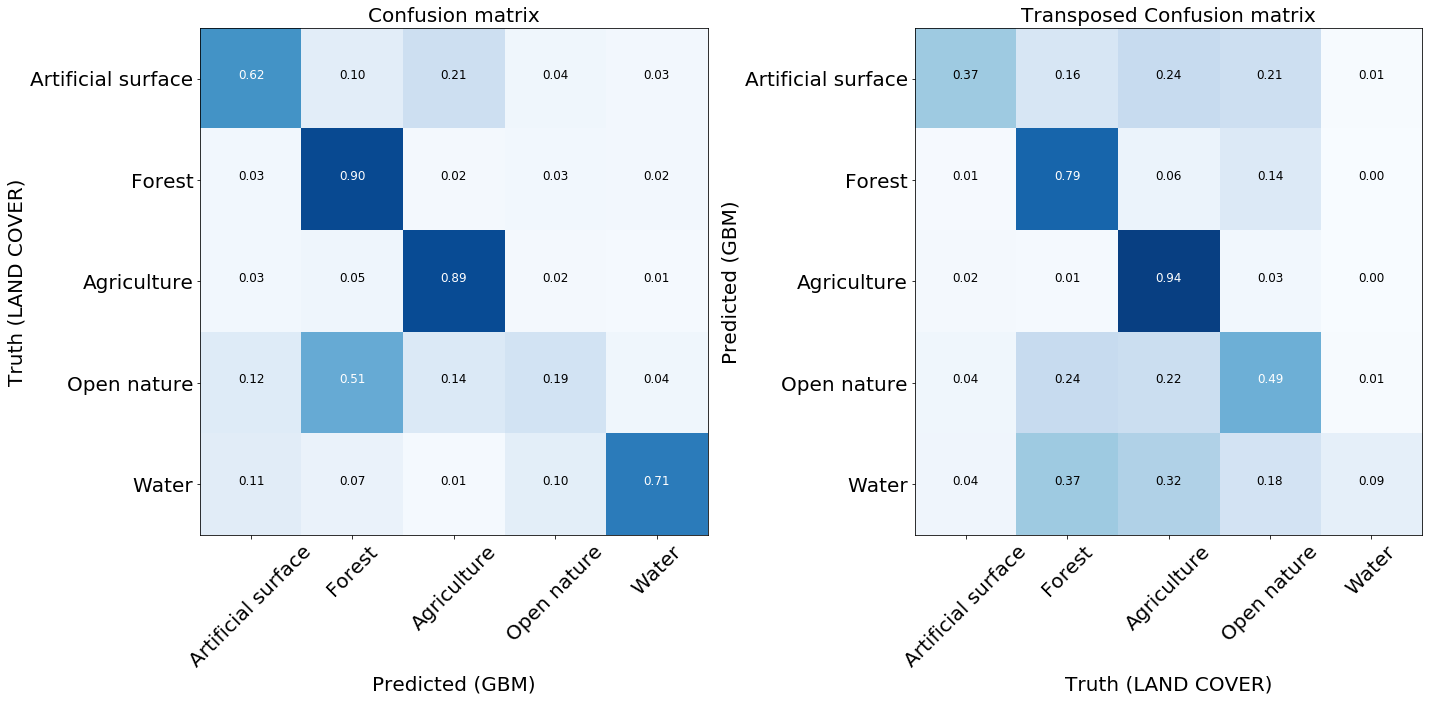

In [44]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (LAND COVER)',
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      xlabel='Truth (LAND COVER)',
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

## Visualization of results

In [45]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name

    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]

        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)

        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)

        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)

        return eopatch

In [46]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out_sampled)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# TASK FOR SAVING
save = SaveToDisk(str(path_out_sampled), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
tiff_location = './example/predicted_tiff'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

In [51]:
execution_args = []

for i in range(len(patchIDs)):
    execution_args = {
        load: {'eopatch_folder': 'eopatch_{}'.format(i)},
        export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)},
        save: {'eopatch_folder': 'eopatch_{}'.format(i)}
    }
    workflow.execute(execution_args)

The prediction is plotted vs. the ground truth

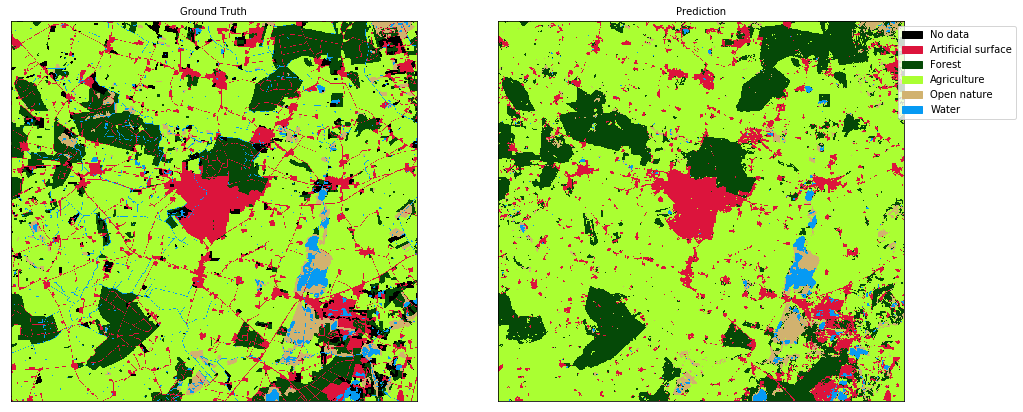

In [52]:
fig = plt.figure(figsize=(16,7))

eopatch = EOPatch.load('./example/eopatches_sampled_large/eopatch_1',lazy_loading=True)

ax = plt.subplot(1,2,1)
plt.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=10)

ax = plt.subplot(1,2,2)
plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=10)

legend_labels = {'black':'No data',
                 'crimson':'Artificial surface',
                 'xkcd:darkgreen':'Forest',
                 'xkcd:lime':'Agriculture',
                 'xkcd:tan':'Open nature',
                 'xkcd:azure':'Water',
                 }

patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, 
          bbox_to_anchor=(1.29,1), 
          facecolor="white")